## Scientific Assessment and Uncertainty Quantification (UQ) for the Energy Indicator Application (DE340.15.1.3)

This notebook provides insights on **how well the climate variables and indicators**, derived from various Climate DT simulations tailored to the wind energy sector, **capture the spatio-temporal characteristics** compared to reference data (ERA5).

---

### Climate DT Simulations Used

1. **E-suite control simulation (o005)**  
   *Period:* 1990–1994 (5 years)  
   *Model:* IFS-NEMO  
   *Domain:* North Sea (5°W–10°E, 50°N–60°N)  
   *Resolution:* 5 km horizontal  
   *Variable of interest:* Capacity Factor class -S  

2. **O-suite control simulation (o007)**  
   *Period:* 1990–2005 (15 years)  
   *Model:* IFS-NEMO  
   *Domain:* North Sea (5°W–10°E, 50°N–60°N)  
   *Resolution:* 5 km horizontal
   *Variable of interest:* Capacity Factor class -S  

---

### Scientific Assessment and UQ Components

- **Comparison with ERA5**
- **Mean Bias (MB)**

---

### Methodology

Energy-indicator application has been run with ERA5 hourly data Off-line.
 
Climate DT simulations are **regridded to the ERA5 grid** using a conservative regridding technique for wind speed and related indicators.  
*Reference:* Ramon et al., 2019 – [https://doi.org/10.1002/qj.3616](https://doi.org/10.1002/qj.3616)

---

### Contact

📧 **energy-destine@bsc.es**    

**Responsible:** Sushovan Ghosh (BSC)


In [2]:
#libraries
import xarray as xr
import xesmf as xe
import os
# For Jupyter Notebooks
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Plotting libraries

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cmocean import cm as cmo
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as pltmask
import matplotlib.gridspec as gs
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches
import matplotlib.colors as mpc
import xesmf as xe
%matplotlib inline


**Monthly climatology of CF-S from IFS-NEMO operational historical end-to-end run [o007]**

            Data used: capacity factor class S monthly climatology (postprocessed)

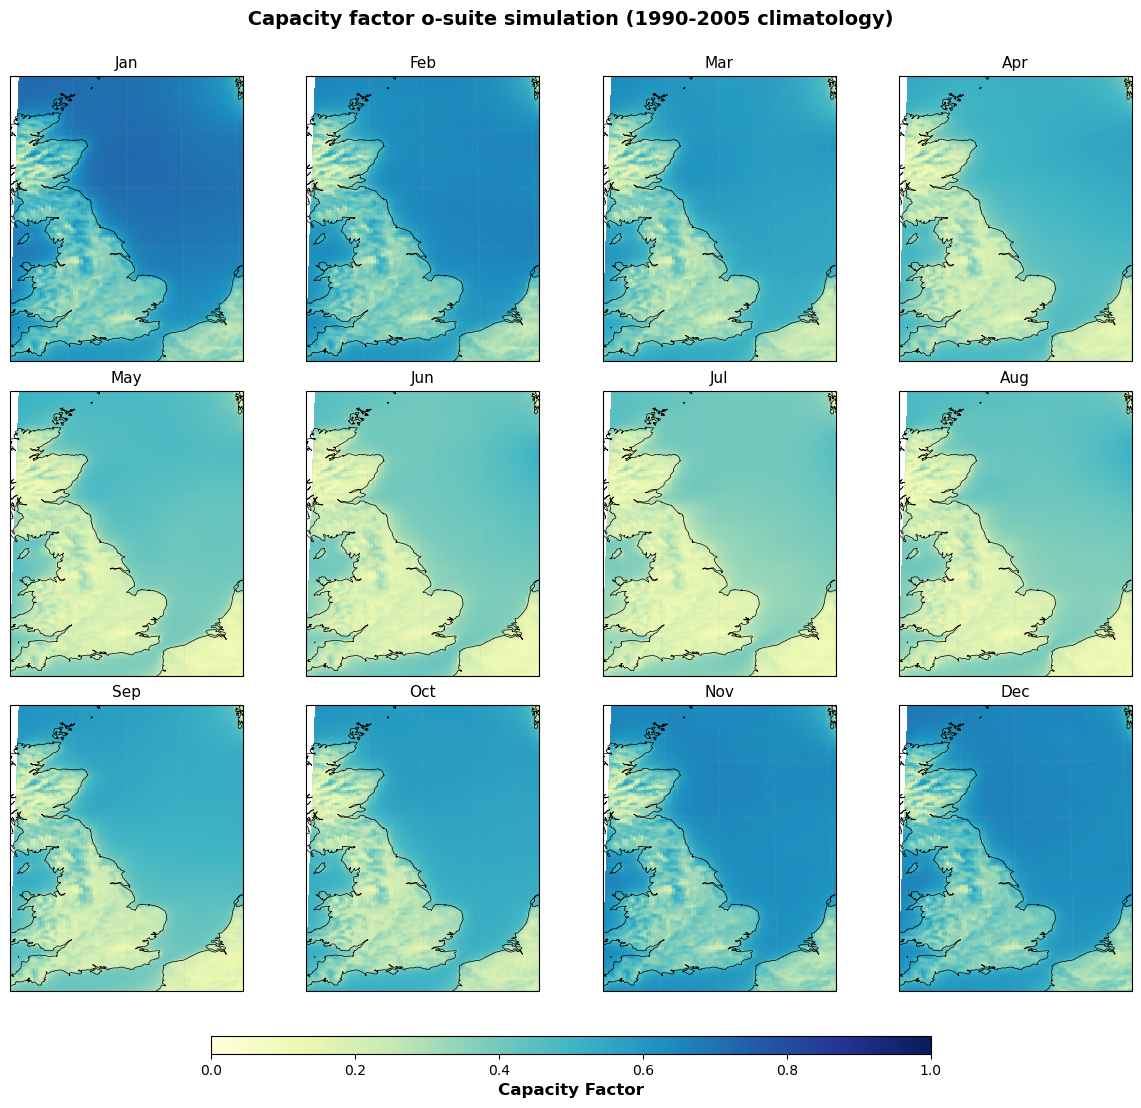

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker


# ── 1. open the 12-month climatology ────────────────────────────────────────
ds   = xr.open_dataset(
    "/gpfs/scratch/bsc32/bsc148104/hist_ensem/IFS_NEMO_o007/cf_S_monthly_climatology_1990_2005.nc"
)                                       # time = 12, lat, lon
cf   = ds["cf_monthly_climatology"]
lats = ds["lat"]
lons = ds["lon"]

# ── 2. figure grid of 3 × 4 panels ──────────────────────────────────────────
fig, axes = plt.subplots(
    3, 4, figsize=(12, 12),
    subplot_kw=dict(projection=ccrs.Robinson())
)
axes = axes.ravel()
month_names = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]

for i, ax in enumerate(axes):
    img = cf.isel(time=i).plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="YlGnBu", vmin=0, vmax=1,
        add_colorbar=False
    )

    ax.set_title(month_names[i], fontsize=11)
    ax.set_extent([-5, 5, 50.025, 59.975], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=False, linewidth=0.2,
                      linestyle="--", alpha=0.5)
    gl.xlocator = mticker.MaxNLocator(5)
    gl.ylocator = mticker.MaxNLocator(5)

# ── 3. shared colour-bar ────────────────────────────────────────────────────
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.015])
cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Capacity Factor", fontsize=12, weight="bold")

plt.suptitle(" Capacity factor o-suite simulation (1990-2005 climatology) ", fontsize=14, fontweight="bold", y=0.95)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.savefig("/home/bsc/bsc148104/esuit_map/monthly_cf_S_IFS_NEMO_o007_climatology.png",
            dpi=300, bbox_inches="tight")
plt.show()


## Running application with ERA5

**Data used:** 
        
        hourly windspeed (100m) --> Energy-indicator --> capacity factor hourly (post processed to monthly climatology)

In [22]:
#Basic libraries
import xarray as xr
import numpy as np
import scipy as sc
import pandas as pd
import os
print('all modules loaded')

all modules loaded


**Running Energy-indicator application**

In [24]:
import xarray as xr
from energy_onshore.core import wind_speed
from energy_onshore import capacity_factor
import os

In [12]:
from pathlib import Path
import re
import xarray as xr
from energy_onshore import capacity_factor   # make sure this import works!

_FILE_RE = re.compile(r"windagl100_(\d{4})(\d{2})\.nc$")

def _to_da(obj):
    """
    Return a DataArray from *obj*.

    * If obj is already a DataArray, return it.
    * If obj is a Dataset with exactly one data variable, return that variable.
    * Otherwise raise.
    """
    if isinstance(obj, xr.DataArray):
        return obj
    if len(obj.data_vars) == 1:
        return next(iter(obj.data_vars.values()))
    raise ValueError(
        "capacity_factor returned a Dataset with multiple vars; "
        "please pick one explicitly"
    )

def make_monthly_cf(
    input_dir,
    output_dir,
    start_year=1990,
    end_year=2005,
    *,
    chunks=None,      # e.g. {"time": 744} for dask
    verbose=True,
):
    """
    Loop over windagl100_YYYYMM.nc files, compute IEC-class-S capacity factor,
    take the monthly mean, and write CF_S_monthly_mean_YYYY_MM.nc files.
    """
    in_dir  = Path(input_dir)
    out_dir = Path(output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    for fp in sorted(in_dir.glob("windagl100_*.nc")):
        m = _FILE_RE.match(fp.name)
        if not m:
            continue
        yy, mm = map(int, m.groups())
        if not (start_year <= yy <= end_year):
            continue

        ds = xr.open_dataset(fp, engine="netcdf4", chunks=chunks)
        if "windagl100" not in ds:
            if verbose:
                print("skip", fp.name, "(variable missing)")
            continue

        ws = ds["windagl100"]
        cf = capacity_factor(ws, iec_class="S")
        cf_da = _to_da(cf)
        cf_month = cf_da.mean("time", skipna=True).rename("CF_S_monthly_mean")

        out_path = out_dir / f"CF_S_monthly_mean_{yy}_{mm:02d}.nc"
        cf_month.to_netcdf(
            out_path,
            encoding={"CF_S_monthly_mean": {"zlib": True}},
            engine="netcdf4"
        )
        if verbose:
            print("saved", out_path)


In [ ]:
# Cell 2 – run the loop on begin year-end year only
make_monthly_cf(
    input_dir  = "/gpfs/scratch/bsc32/bsc148104/ERA5/hourly_windagl100",
    output_dir = "/gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S",
    start_year = 1996,
    end_year   = 2005,
    chunks     = {"time": 744},   # comment out if you don't use Dask
)


saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_01.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_02.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_03.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_04.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_05.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_06.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_07.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_08.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_09.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/CF_S_monthly_mean_1996_10.nc
saved /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_

In [11]:
from pathlib import Path
import xarray as xr
import numpy as np


def build_monthly_climatology(
    monthly_dir,
    outfile,
    start_year=1990,
    end_year=2005,
):
    monthly_dir = Path(monthly_dir)
    dalist = []

    for p in sorted(monthly_dir.glob("CF_S_monthly_mean_*.nc")):
        try:
            y, m = map(int, p.stem.split("_")[-2:])
        except ValueError:
            continue
        if not (start_year <= y <= end_year):
            continue

        da = xr.open_dataset(p)["CF_S_monthly_mean"]
        timestamp = np.datetime64(f"{y}-{m:02d}-15")  # middle of the month
        da = da.expand_dims(time=[timestamp])
        dalist.append(da)

    if not dalist:
        raise RuntimeError("No monthly-mean files found in the requested span")

    combined = xr.concat(dalist, dim="time")

    climatology = (
        combined.groupby("time.month")
                .mean("time", skipna=True)
                .rename(month="time")
                .assign_coords(time=np.arange(1, 13))
                .to_dataset(name="CF_S_monthly_mean")
    )

    climatology.to_netcdf(
        outfile, encoding={"CF_S_monthly_mean": {"zlib": True}}
    )
    print("✓ wrote", outfile)


In [21]:
build_monthly_climatology(
    monthly_dir = "/gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S",
    outfile     = "/gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/cf_S_monthly_climatology_ERA5_1990_2005.nc",
    start_year  = 1990,
    end_year    = 2005,
)


/scratch/tmp/25135443/ipykernel_825900/8161073.py:25: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  da = da.expand_dims(time=[timestamp])
/scratch/tmp/25135443/ipykernel_825900/8161073.py:25: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by conve

✓ wrote /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/cf_S_monthly_climatology_ERA5_1990_2005.nc


In [12]:
build_monthly_climatology(
    monthly_dir = "/gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S",
    outfile     = "/home/bsc/bsc148104/esuit_map/cf_S_monthly_climatology_ERA5_1990_1994.nc",
    start_year  = 1990,
    end_year    = 1994,
)


✓ wrote /home/bsc/bsc148104/esuit_map/cf_S_monthly_climatology_ERA5_1990_1994.nc


In [37]:
#!/usr/bin/env python3
"""
Crop ERA-5 monthly climatology to the North Sea
(lon –5…5 °E, lat 50…60 °N) and write *_NS.nc.

Works even if the source longitude axis is 0–360° and
latitude is descending (ERA-5 default).
"""

from pathlib import Path
import xarray as xr

# ── 1. paths ────────────────────────────────────────────────────────────────
in_path = Path(
    "/gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/"
    "cf_S_monthly_climatology_ERA5_1990_2005.nc"
)
out_path = in_path.with_name(in_path.stem + "_NS.nc")

# ── 2. open + wrap longitude to –180…180 ────────────────────────────────────
ds = xr.open_dataset(in_path)
ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180)  # 0–360 → –180…180
ds = ds.sortby("lon")                                    # make lon ascending

# ── 3. crop lon / lat (ERA-5 latitude is descending) ────────────────────────
cropped = (
    ds.sel(lon=slice(-5, 5),
           lat=slice(60, 50))   # high→low works on descending latitude
      .sortby("lat")            # tidy: final lat ascending
)

# ── 4. save ─────────────────────────────────────────────────────────────────
cropped.to_netcdf(out_path)
print(f"✔ North-Sea subset saved → {out_path}")


✔ North-Sea subset saved → /gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/cf_S_monthly_climatology_ERA5_1990_2005_NS.nc


**creating monthly climatology file over north sea region for e-suite runs**

In [13]:
# creating monthly climatology file over north sea region for e-suite runs
"""
Crop ERA-5 monthly climatology to the North Sea
(lon –5…5 °E, lat 50…60 °N) and write *_NS.nc.

Works even if the source longitude axis is 0–360° and
latitude is descending (ERA-5 default).
"""

from pathlib import Path
import xarray as xr

# ── 1. paths ────────────────────────────────────────────────────────────────
in_path = Path(
    "/home/bsc/bsc148104/esuit_map/"
    "cf_S_monthly_climatology_ERA5_1990_1994.nc"
)
out_path = in_path.with_name(in_path.stem + "_NS.nc")

# ── 2. open + wrap longitude to –180…180 ────────────────────────────────────
ds = xr.open_dataset(in_path)
ds = ds.assign_coords(lon=((ds.lon + 180) % 360) - 180)  # 0–360 → –180…180
ds = ds.sortby("lon")                                    # make lon ascending

# ── 3. crop lon / lat (ERA-5 latitude is descending) ────────────────────────
cropped = (
    ds.sel(lon=slice(-5, 5),
           lat=slice(60, 50))   # high→low works on descending latitude
      .sortby("lat")            # tidy: final lat ascending
)

# ── 4. save ─────────────────────────────────────────────────────────────────
cropped.to_netcdf(out_path)
print(f"✔ North-Sea subset saved → {out_path}")


✔ North-Sea subset saved → /home/bsc/bsc148104/esuit_map/cf_S_monthly_climatology_ERA5_1990_1994_NS.nc


/scratch/tmp/25135443/ipykernel_825900/1782477898.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 0.95])


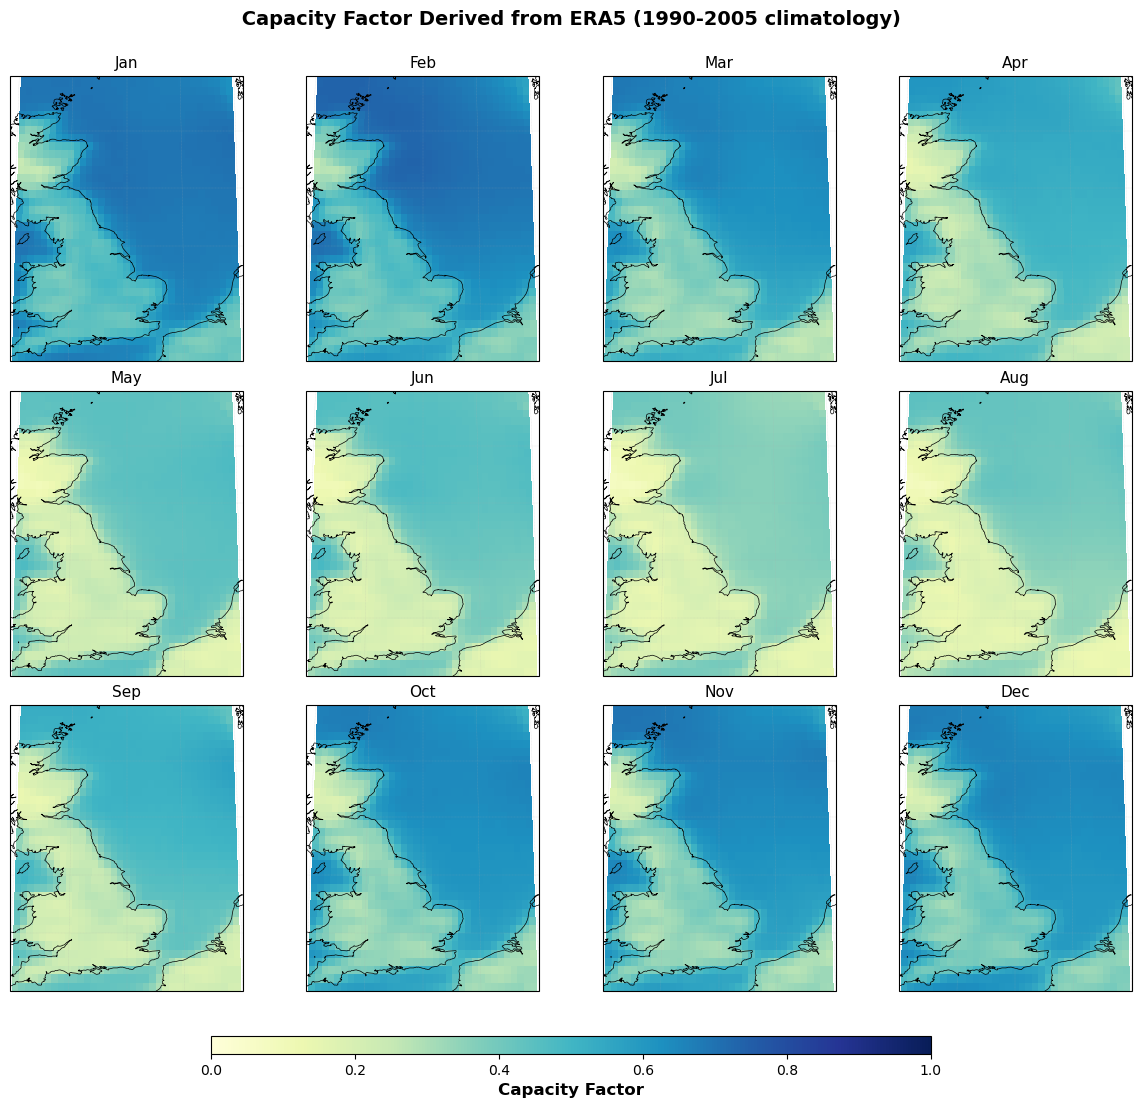

In [39]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker


# ── 1. open the 12-month climatology ────────────────────────────────────────
ds   = xr.open_dataset(
    "/gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/cf_S_monthly_climatology_ERA5_1990_2005_NS.nc"
)                                       # time = 12, lat, lon
cf   = ds["CF_S_monthly_mean"]
lats = ds["lat"]
lons = ds["lon"]

# ── 2. figure grid of 3 × 4 panels ──────────────────────────────────────────
fig, axes = plt.subplots(
    3, 4, figsize=(12, 12),
    subplot_kw=dict(projection=ccrs.Robinson())
)
axes = axes.ravel()
month_names = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]

for i, ax in enumerate(axes):
    img = cf.isel(time=i).plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="YlGnBu", vmin=0, vmax=1,
        add_colorbar=False
    )

    ax.set_title(month_names[i], fontsize=11)
    ax.set_extent([-5, 5, 50.025, 59.975], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=False, linewidth=0.2,
                      linestyle="--", alpha=0.5)
    gl.xlocator = mticker.MaxNLocator(5)
    gl.ylocator = mticker.MaxNLocator(5)

# ── 3. shared colour-bar ────────────────────────────────────────────────────
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.015])
cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Capacity Factor", fontsize=12, weight="bold")

plt.suptitle(" Capacity Factor Derived from ERA5 (1990-2005 climatology) ", fontsize=14, fontweight="bold", y=0.95)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.savefig("/home/bsc/bsc148104/esuit_map/monthly_cf_S_IFS_NEMO_ERA5_Derived_1990_2005_climatology.png",
            dpi=300, bbox_inches="tight")
plt.show()


**Creating regridded CF-S for o-suite run to match with the ERA5 Grid**

In [41]:
#!/usr/bin/env python3
"""
Conservatively regrid IFS-NEMO climatology (301 × 200 grid)
onto the ERA-5 North-Sea grid (35 × 36) and write:

    cf_S_monthly_climatology_1990_2005_regrid_to_ERA5.nc
"""

from pathlib import Path
import xarray as xr
import xesmf as xe

# ── paths ───────────────────────────────────────────────────────────────────
model_dir = Path("/gpfs/scratch/bsc32/bsc148104/hist_ensem/IFS_NEMO_o007")
era5_dir  = Path("/gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S")

src_path = model_dir / "cf_S_monthly_climatology_1990_2005.nc"
tgt_path = era5_dir / "cf_S_monthly_climatology_ERA5_1990_2005_NS.nc"
out_path = model_dir / "cf_S_monthly_climatology_1990_2005_regrid_to_ERA5.nc"
wgt_path = model_dir / "weights_model_to_era5_conserv.nc"    # will be created

# ── open source & target ────────────────────────────────────────────────────
src_ds = xr.open_dataset(src_path)                 # (time, lat, lon) 200×301
tgt_ds = xr.open_dataset(tgt_path)                 # (time, lat, lon)  36×35

src_da = src_ds["cf_monthly_climatology"]
tgt_grid = xr.Dataset({                           # only coordinates needed
    "lon": (("lon",), tgt_ds.lon.data),
    "lat": (("lat",), tgt_ds.lat.data),
})

# ── build conservative regridder  (compute weights once) ────────────────────
regridder = xe.Regridder(
    src_da, tgt_grid,
    method="conservative",
    periodic=False,
    filename=wgt_path,         # where weights are stored
    reuse_weights=False        # ← CREATE weights because file is new
)

# ── regrid & tidy ───────────────────────────────────────────────────────────
dst_da = regridder(src_da)
dst_da.name = "cf_monthly_climatology"
dst_da.attrs.update(src_da.attrs)

dst_ds = dst_da.to_dataset()
dst_ds["lat"] = tgt_ds.lat
dst_ds["lon"] = tgt_ds.lon

# ── save ────────────────────────────────────────────────────────────────────
dst_ds.to_netcdf(out_path)
print(f"✔ regridded file written → {out_path}")
print(f"✔ weight file written   → {wgt_path}")

"""
Next run you can switch   reuse_weights=True
and the script will finish instantly:

regridder = xe.Regridder(
    src_da, tgt_grid, "conservative",
    periodic=False, filename=wgt_path, reuse_weights=True)
"""


✔ regridded file written → /gpfs/scratch/bsc32/bsc148104/hist_ensem/IFS_NEMO_o007/cf_S_monthly_climatology_1990_2005_regrid_to_ERA5.nc
✔ weight file written   → /gpfs/scratch/bsc32/bsc148104/hist_ensem/IFS_NEMO_o007/weights_model_to_era5_conserv.nc


'\nNext run you can switch   reuse_weights=True\nand the script will finish instantly:\n\nregridder = xe.Regridder(\n    src_da, tgt_grid, "conservative",\n    periodic=False, filename=wgt_path, reuse_weights=True)\n'

**Creating regridded CF-S for e-suite run to match with the ERA5 Grid**

In [14]:
#!/usr/bin/env python3
"""
Conservatively regrid IFS-NEMO climatology (301 × 200 grid)
onto the ERA-5 North-Sea grid (35 × 36) and write:

    cf_S_monthly_climatology_1990_2005_regrid_to_ERA5.nc
"""

from pathlib import Path
import xarray as xr
import xesmf as xe

# ── paths ───────────────────────────────────────────────────────────────────
model_dir = Path("/home/bsc/bsc148104/esuit_map")
era5_dir  = Path("/home/bsc/bsc148104/esuit_map")

src_path = model_dir / "cf_climatology_climatedt_1990_1994.nc"
tgt_path = era5_dir / "cf_S_monthly_climatology_ERA5_1990_1994_NS.nc"
out_path = model_dir / "cf_S_monthly_climatology_1990_1994_regrid_to_ERA5_esuite.nc"
wgt_path = model_dir / "weights_model_to_era5_conserv.nc"    # will be created

# ── open source & target ────────────────────────────────────────────────────
src_ds = xr.open_dataset(src_path)                 # (time, lat, lon) 200×301
tgt_ds = xr.open_dataset(tgt_path)                 # (time, lat, lon)  36×35

src_da = src_ds["cf"]
tgt_grid = xr.Dataset({                           # only coordinates needed
    "lon": (("lon",), tgt_ds.lon.data),
    "lat": (("lat",), tgt_ds.lat.data),
})

# ── build conservative regridder  (compute weights once) ────────────────────
regridder = xe.Regridder(
    src_da, tgt_grid,
    method="conservative",
    periodic=False,
    filename=wgt_path,         # where weights are stored
    reuse_weights=False        # ← CREATE weights because file is new
)

# ── regrid & tidy ───────────────────────────────────────────────────────────
dst_da = regridder(src_da)
dst_da.name = "cf_monthly_climatology"
dst_da.attrs.update(src_da.attrs)

dst_ds = dst_da.to_dataset()
dst_ds["lat"] = tgt_ds.lat
dst_ds["lon"] = tgt_ds.lon

# ── save ────────────────────────────────────────────────────────────────────
dst_ds.to_netcdf(out_path)
print(f"✔ regridded file written → {out_path}")
print(f"✔ weight file written   → {wgt_path}")

"""
Next run you can switch   reuse_weights=True
and the script will finish instantly:

regridder = xe.Regridder(
    src_da, tgt_grid, "conservative",
    periodic=False, filename=wgt_path, reuse_weights=True)
"""


✔ regridded file written → /home/bsc/bsc148104/esuit_map/cf_S_monthly_climatology_1990_1994_regrid_to_ERA5_esuite.nc
✔ weight file written   → /home/bsc/bsc148104/esuit_map/weights_model_to_era5_conserv.nc


'\nNext run you can switch   reuse_weights=True\nand the script will finish instantly:\n\nregridder = xe.Regridder(\n    src_da, tgt_grid, "conservative",\n    periodic=False, filename=wgt_path, reuse_weights=True)\n'

In [43]:

from pathlib import Path
import xarray as xr
import xesmf as xe
# ─────────────────────────────────────────────────────────────────────────────
#  configuration (edit paths as needed)
# ─────────────────────────────────────────────────────────────────────────────
model_file = (
    "/gpfs/scratch/bsc32/bsc148104/hist_ensem/IFS_NEMO_o007/"
    "cf_S_monthly_climatology_1990_2005_regrid_to_ERA5.nc"
)
era5_file = (
    "/gpfs/scratch/bsc32/bsc148104/hist_ensem/ERA5_derived_CF_S/"
    "cf_S_monthly_climatology_ERA5_1990_2005_NS.nc"
)

VAR_MODEL = "cf_monthly_climatology"   # variable names in the files
VAR_ERA5  = "CF_S_monthly_mean"

north_sea_extent = [-5, 5, 50, 60]     # lon W,E   lat S,N

# 1. open & align ------------------------------------------------------------
ds_mod  = xr.open_dataset(model_file)[VAR_MODEL]
ds_ref  = xr.open_dataset(era5_file)[VAR_ERA5]

# make sure coordinates match (they should after regridding)
ds_ref, ds_mod = xr.align(ds_ref, ds_mod, join="exact")

bias = ds_mod - ds_ref                  # (time, lat, lon)
bias.name = "mean_bias"

/scratch/tmp/25135443/ipykernel_825900/4140538925.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 0.95])


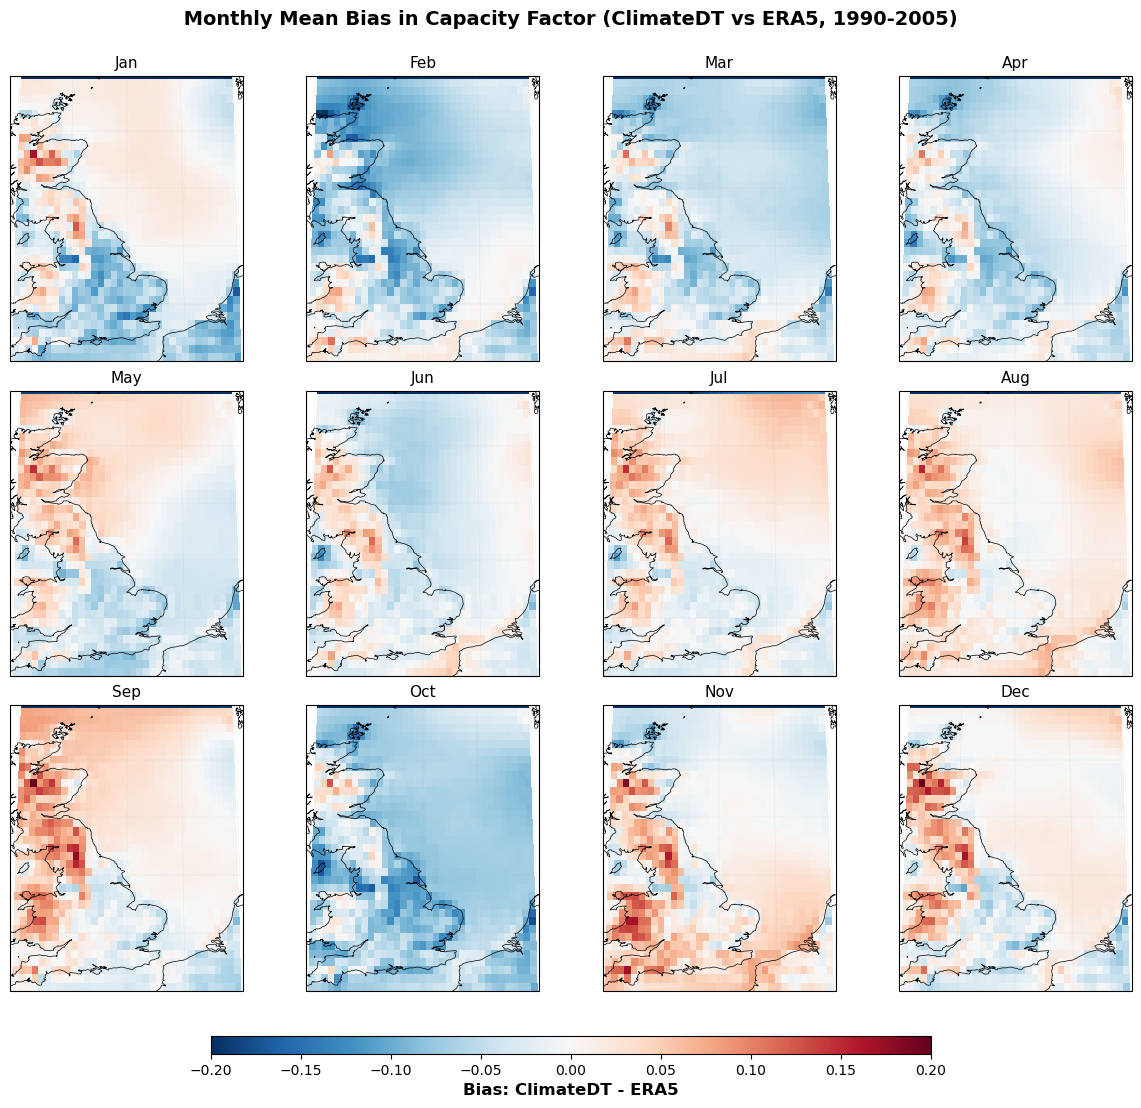

In [47]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker

# ── 2. figure grid of 3 × 4 panels ──────────────────────────────────────────
fig, axes = plt.subplots(
    3, 4, figsize=(12, 12),
    subplot_kw=dict(projection=ccrs.Robinson())
)
axes = axes.ravel()
month_names = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]

for i, ax in enumerate(axes):
    img = bias.isel(time=i).plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=-0.20, vmax=0.20,
        add_colorbar=False
    )

    ax.set_title(month_names[i], fontsize=11)
    ax.set_extent([-5, 5, 50.025, 59.97], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=False, linewidth=0.2,
                      linestyle="--", alpha=0.5)
    gl.xlocator = mticker.MaxNLocator(5)
    gl.ylocator = mticker.MaxNLocator(5)

# ── 3. shared colour-bar ────────────────────────────────────────────────────
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.015])
cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Bias: ClimateDT - ERA5", fontsize=12, weight="bold")

plt.suptitle(" Monthly Mean Bias in Capacity Factor (ClimateDT vs ERA5, 1990-2005) ", fontsize=14, fontweight="bold", y=0.95)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.savefig("/home/bsc/bsc148104/esuit_map/monthly_mean_bias_cf_S_IFS_NEMO_vs_ERA5_Derived_1990_2005_climatology.png",
            dpi=300, bbox_inches="tight")
plt.show()


### Climate DT Simulations Used

1. **E-suite control simulation (o005)**  
   *Period:* 1990–1994 (5 years)  
   *Model:* IFS-NEMO  
   *Domain:* North Sea (5°W–10°E, 50°N–60°N)  
   *Resolution:* 5 km horizontal  
   *Variable of interest:* Capacity Factor class -S  

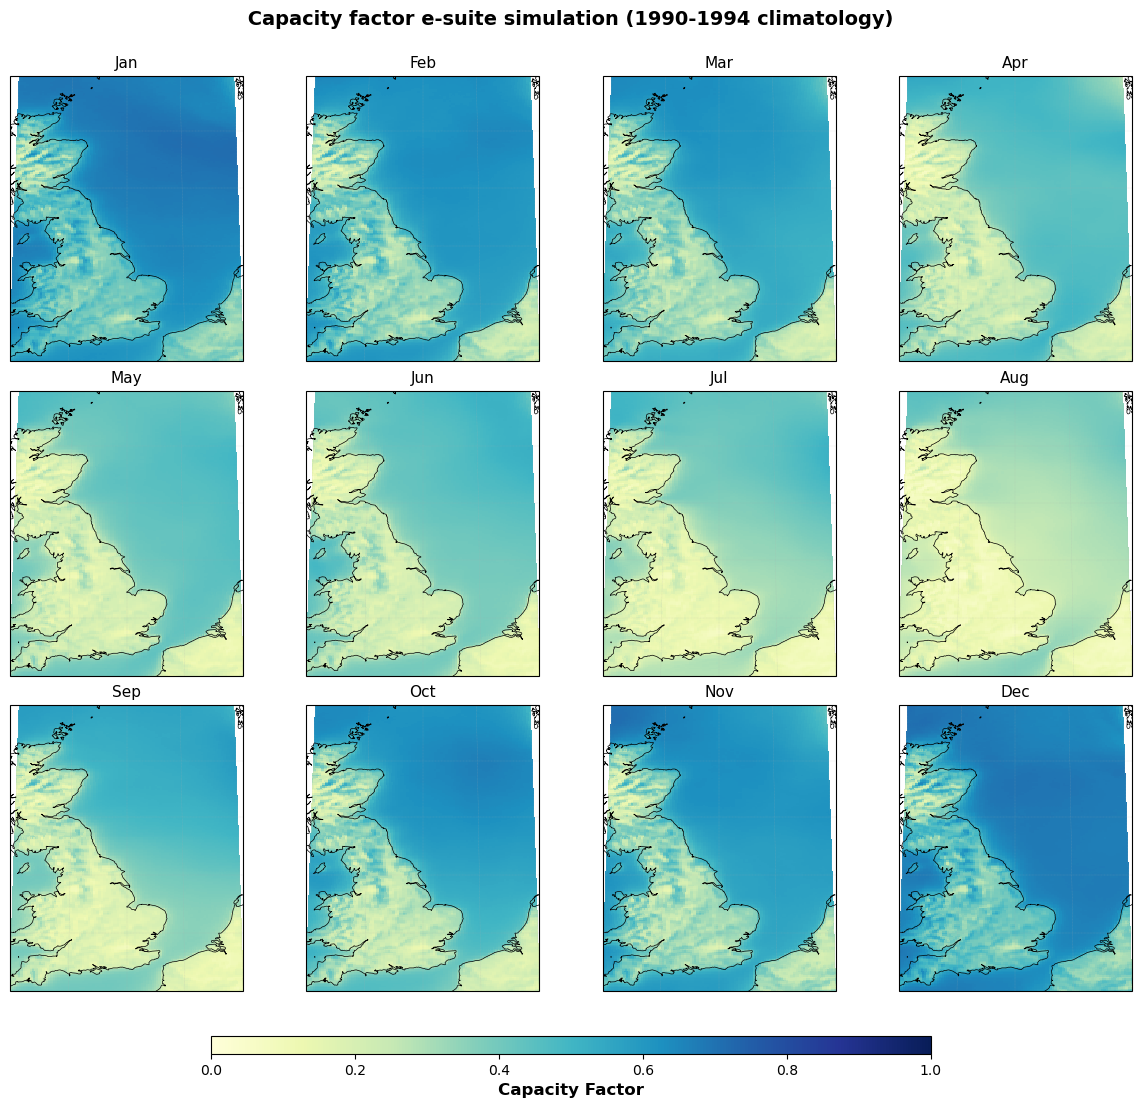

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker


# ── 1. open the 12-month climatology ────────────────────────────────────────
ds   = xr.open_dataset(
    "/home/bsc/bsc148104/esuit_map/cf_climatology_climatedt_1990_1994.nc"
)                                       # time = 12, lat, lon
cf   = ds["cf"]
lats = ds["lat"]
lons = ds["lon"]

# ── 2. figure grid of 3 × 4 panels ──────────────────────────────────────────
fig, axes = plt.subplots(
    3, 4, figsize=(12, 12),
    subplot_kw=dict(projection=ccrs.Robinson())
)
axes = axes.ravel()
month_names = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]

for i, ax in enumerate(axes):
    img = cf.isel(time=i).plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="YlGnBu", vmin=0, vmax=1,
        add_colorbar=False
    )

    ax.set_title(month_names[i], fontsize=11)
    ax.set_extent([-5, 5, 50.025, 59.975], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=False, linewidth=0.2,
                      linestyle="--", alpha=0.5)
    gl.xlocator = mticker.MaxNLocator(5)
    gl.ylocator = mticker.MaxNLocator(5)

# ── 3. shared colour-bar ────────────────────────────────────────────────────
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.015])
cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Capacity Factor", fontsize=12, weight="bold")

plt.suptitle(" Capacity factor e-suite simulation (1990-1994 climatology) ", fontsize=14, fontweight="bold", y=0.95)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.savefig("/home/bsc/bsc148104/esuit_map/monthly_cf_S_IFS_NEMO_o007_climatology.png",
            dpi=300, bbox_inches="tight")
plt.show()


**Estimate the mean bias monthly climatology (1990-1994)**


In [16]:

from pathlib import Path
import xarray as xr
import xesmf as xe
# ─────────────────────────────────────────────────────────────────────────────
#  configuration (edit paths as needed)
# ─────────────────────────────────────────────────────────────────────────────
model_file = (
    "/home/bsc/bsc148104/esuit_map/"
    "cf_S_monthly_climatology_1990_1994_regrid_to_ERA5_esuite.nc"
)
era5_file = (
    "/home/bsc/bsc148104/esuit_map/"
    "cf_S_monthly_climatology_ERA5_1990_1994_NS.nc"
)

VAR_MODEL = "cf_monthly_climatology"   # variable names in the files
VAR_ERA5  = "CF_S_monthly_mean"

north_sea_extent = [-5, 5, 50, 60]     # lon W,E   lat S,N

# 1. open & align ------------------------------------------------------------
ds_mod  = xr.open_dataset(model_file)[VAR_MODEL]
ds_ref  = xr.open_dataset(era5_file)[VAR_ERA5]

# make sure coordinates match (they should after regridding)
ds_ref, ds_mod = xr.align(ds_ref, ds_mod, join="exact")

bias = ds_mod - ds_ref                  # (time, lat, lon)
bias.name = "mean_bias"

**Plotting: mean bias monthly climatology basis**

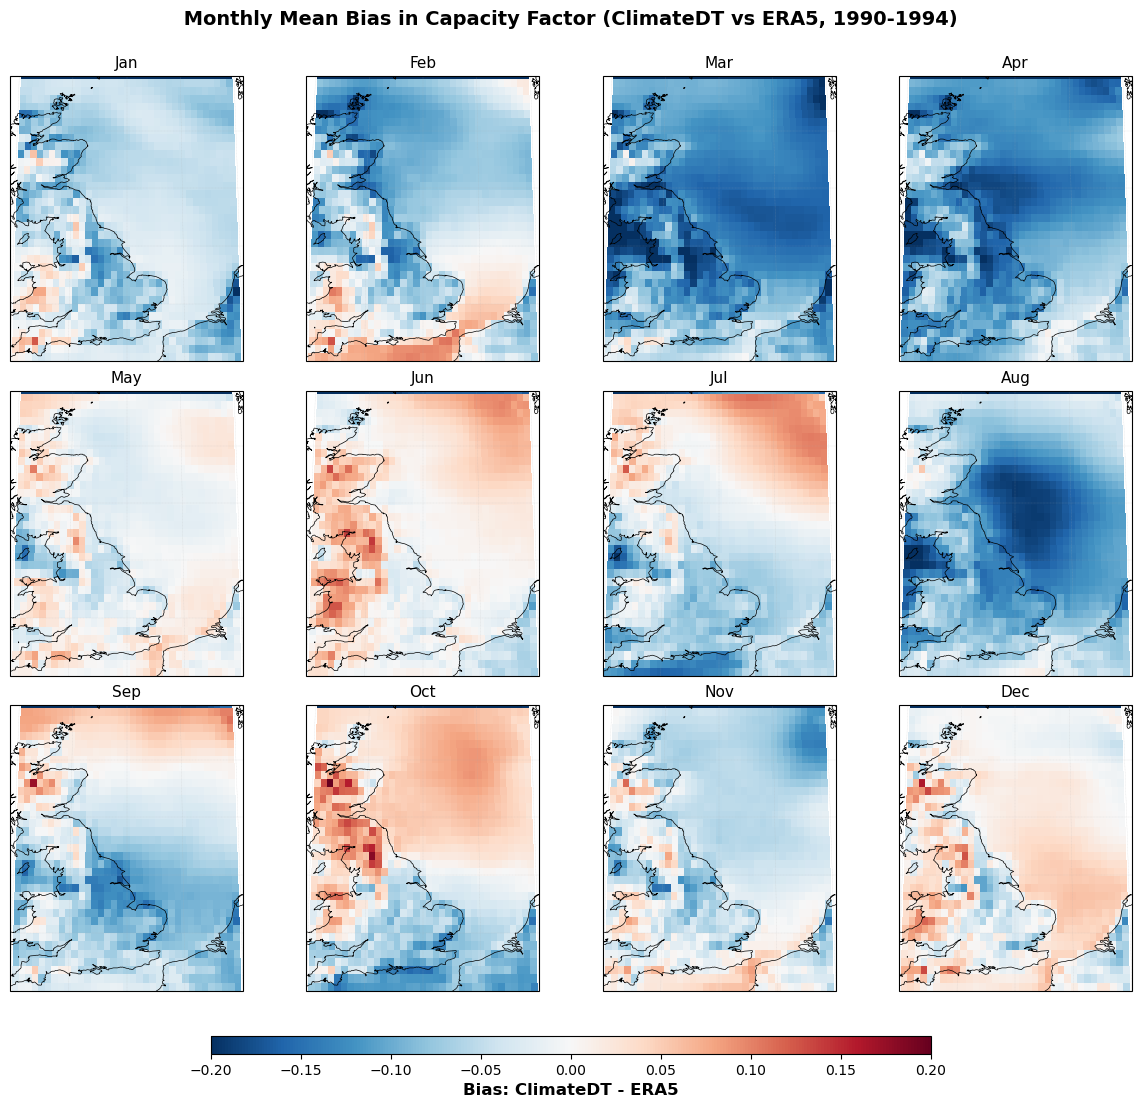

In [17]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker

# ── 2. figure grid of 3 × 4 panels ──────────────────────────────────────────
fig, axes = plt.subplots(
    3, 4, figsize=(12, 12),
    subplot_kw=dict(projection=ccrs.Robinson())
)
axes = axes.ravel()
month_names = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]

for i, ax in enumerate(axes):
    img = bias.isel(time=i).plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=-0.20, vmax=0.20,
        add_colorbar=False
    )

    ax.set_title(month_names[i], fontsize=11)
    ax.set_extent([-5, 5, 50.025, 59.97], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=False, linewidth=0.2,
                      linestyle="--", alpha=0.5)
    gl.xlocator = mticker.MaxNLocator(5)
    gl.ylocator = mticker.MaxNLocator(5)

# ── 3. shared colour-bar ────────────────────────────────────────────────────
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.015])
cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal")
cbar.set_label("Bias: ClimateDT - ERA5", fontsize=12, weight="bold")

plt.suptitle(" Monthly Mean Bias in Capacity Factor (ClimateDT vs ERA5, 1990-1994) ", fontsize=14, fontweight="bold", y=0.95)
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.tight_layout(rect=[0, 0.12, 1, 0.95])
plt.savefig("/home/bsc/bsc148104/esuit_map/monthly_mean_bias_cf_S_IFS_NEMO_vs_ERA5_Derived_1990_1994_climatology.png",
            dpi=300, bbox_inches="tight")
plt.show()
